# Perturbation Experiments

### Data Preprocessing

In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import sklearn
scv.set_figure_params()

In [2]:
adata = scv.datasets.pancreas()
adata_raw = adata.copy()

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.filter_and_normalize(adata_raw, log=False, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


recovering dynamics (using 2/28 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:04:36) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 2/28 cores)
    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


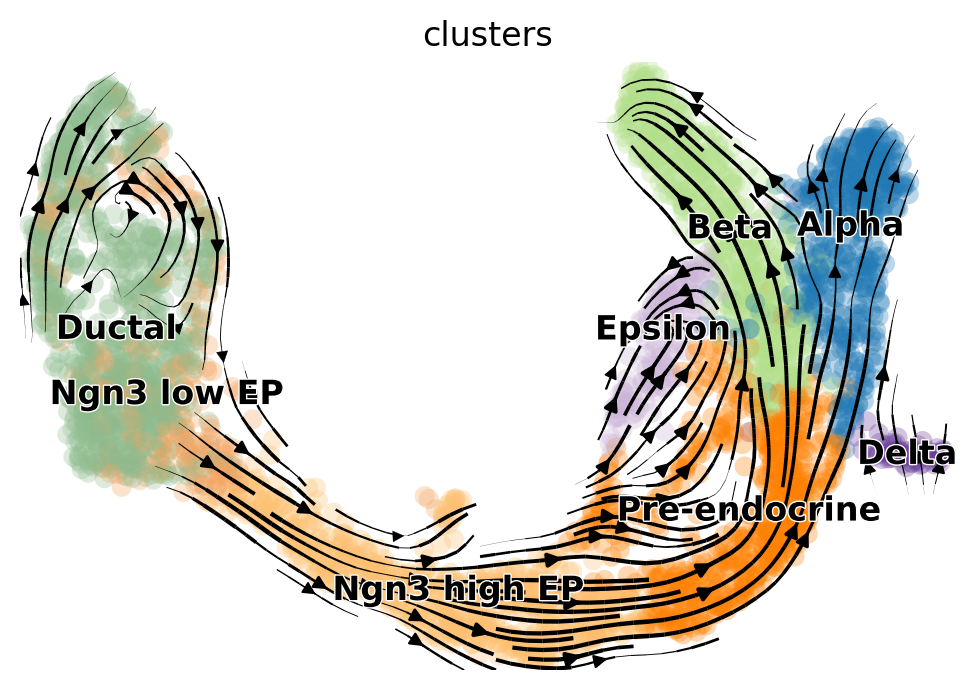

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


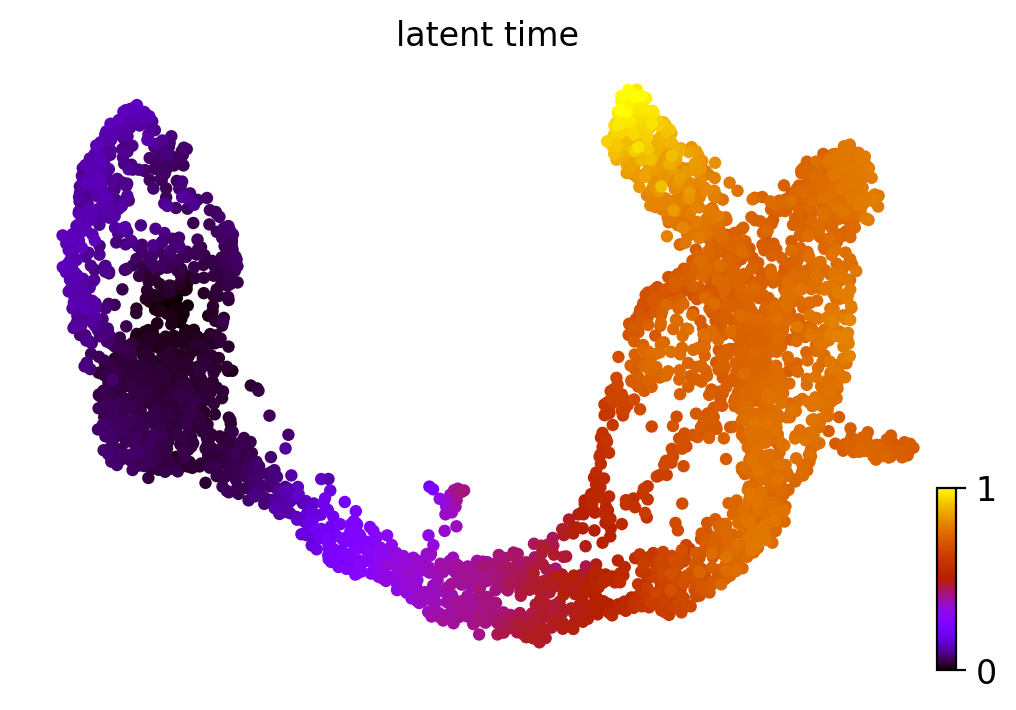

In [4]:
# Extract dynamical velocity vectors
scv.tl.recover_dynamics(adata, n_jobs=2)
scv.tl.velocity(adata, mode='dynamical', use_raw=True)
scv.tl.velocity_graph(adata, n_jobs=2)
scv.pl.velocity_embedding_stream(adata, basis='umap')

# Latent time inference
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

In [5]:
X = np.tile(adata_raw.X.A[:, adata.var["velocity_genes"]], (5, 1))
Y = np.tile(adata.layers["velocity"][:, adata.var["velocity_genes"]], (5, 1))
noise_sigma = (adata_raw.X.A.std()/70)**2
X[adata_raw.shape[0]:, :] += \
    np.random.normal(0, noise_sigma, X[adata_raw.shape[0]:, :].shape)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, 
                                                    Y, 
                                                    test_size=0.1, 
                                                    random_state=42)

# we see that noise has been added to denoise the autoencoder
print(X[:100])
print(X[adata_raw.shape[0]:(adata_raw.shape[0]+100), :])

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.8759722 0.        0.        ... 1.7519444 0.        0.       ]
 [0.        0.        0.        ... 0.        1.5218673 0.       ]
 ...
 [0.        0.        0.        ... 1.3494554 0.        0.       ]
 [0.5701924 0.5701924 0.        ... 4.561539  0.        0.       ]
 [0.        0.        0.        ... 0.9822391 0.        0.       ]]
[[ 3.31069948e-03 -5.58658876e-03  9.79977194e-03 ...  5.35742147e-03
   1.04569430e-02  4.21234872e-03]
 [ 8.81453812e-01  3.86451487e-04 -2.65926961e-03 ...  1.76388121e+00
  -8.32972582e-03 -2.66177952e-03]
 [-2.58495263e-03 -4.95831715e-03 -7.07113976e-03 ...  7.64016341e-03
   1.51588964e+00 -8.05833656e-03]
 ...
 [ 1.01943128e-02  7.62788719e-03  7.69944815e-03 ...  1.35446155e+00
   4.09666123e-03  1.52987279e-02]
 [ 5.86382926e-01  5.63273430e-01  1.11628305e-02 ...  4.56582308e+00
   1.27285141e-02  2.64340197e-03]
 [ 5.46750845e-03 -5.89456595e-03  8.21919180e-04 ...  9.81972

### Model Training

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
input_dim = keras.Input(shape=(X.shape[1],))
encoded = layers.Dense(64, kernel_regularizer=keras.regularizers.l1(1e-6))(input_dim)
encoded = layers.Dense(16, kernel_regularizer=keras.regularizers.l1(1e-2))(encoded)

decoded = layers.Dense(16, kernel_regularizer=keras.regularizers.l1(1e-4))(encoded)
decoded = layers.Dense(64, kernel_regularizer=keras.regularizers.l1(1e-6))(decoded)
decoded = layers.Dense(Y.shape[1])(decoded)

# This model maps an input to its reconstruction
encoder = keras.Model(input_dim, encoded)
autoencoder = keras.Model(input_dim, decoded)

opt = keras.optimizers.Adam(learning_rate=0.00007)
autoencoder.compile(optimizer=opt, loss='mse')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1027)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                65792     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_4 (Dense)              (None, 1027)              66755     
Total params: 134,947
Trainable params: 134,947
Non-trainable params: 0
_____________________________________________________

2021-10-14 18:01:49.860532: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-14 18:01:50.281982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10801 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:83:00.0, compute capability: 3.7


In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
autoencoder.fit(X_train, y_train,
        epochs=100,
        batch_size=2,
        shuffle=True,
        validation_data=(X_test, y_test),
        callbacks=[es])
autoencoder.save("ae_perturb.h5")

### Initial Random Simulation

In [5]:
from scipy.integrate import odeint, solve_ivp
import umap
import matplotlib.pyplot as plt

In [11]:
pca = sklearn.decomposition.PCA(n_components=30)
adata_pca = pca.fit_transform(np.log1p(adata_raw.X.A[:, adata.var["velocity_genes"]]))
umap_reducer = umap.UMAP(random_state=42)
adata_umap = umap_reducer.fit_transform(adata_pca)
neigh = sklearn.neighbors.NearestNeighbors(n_neighbors=30)
neigh.fit(adata_pca)

# ODE Solver Function
def raw_ae(t, in_x):
    input_x = tf.convert_to_tensor(np.expand_dims(in_x, axis=0))
    dx = autoencoder.predict(input_x).flatten()
    return dx

# Interpolate over time
def interpolate(y0, neigh=neigh, pca=pca, umap_reducer=umap_reducer, steps=15, intermediate_steps=5):
    
    solution = []
    for step in range(steps):
        
        # Interpolate using autoencoder
        t_eval = list(range(intermediate_steps))
        noise = np.random.normal(0, adata.var["fit_variance"][adata.var["velocity_genes"]], 
                                  y0.shape[0])
        sol = solve_ivp(raw_ae, [0,max(t_eval)], y0+noise, method="RK23", t_eval=t_eval)
        y = sol.y.T
        
        # Lower dimensionality
        ending_pt_pca = pca.transform(np.nan_to_num(np.log1p(y)))
        
        # Find knn reference points
        interp_neigh = neigh.kneighbors(ending_pt_pca)
        
        # New reference point
        y0 = np.median(X[interp_neigh[1][-1, :], :], axis=0)
        solution.append(y0)
    
    return np.array(solution)

In [12]:
n_iter = 1000
starting_cells = np.zeros((n_iter, X.shape[1]))
terminal_cells = np.zeros((n_iter, X.shape[1]))
y0 = np.median(adata_raw.X[np.ix_(np.where(adata.obs.clusters == "Pre-endocrine")[0], 
                                   adata.var["velocity_genes"])].A, 
               axis=0)
y0_var = adata_raw.X[:, adata.var["velocity_genes"]].A.var(axis=0)
for i in range(n_iter):
    
    if (i % 50 == 0):
        print(i)
        with open('terminal_cells.npy', 'wb') as f:
            np.save(f, np.vstack([starting_cells, terminal_cells]))
    
    # Solve for the cell with initial & velocity noise
    y0_noise = np.random.laplace(0, np.sqrt(y0_var/2), y0.shape[0])
    y_solution = interpolate(y0+y0_noise, neigh = neigh, pca = pca, umap_reducer = umap_reducer)
    starting_cells[i] = y_solution[0, :]
    terminal_cells[i] = y_solution[-1, :]
    
with open('terminal_cells.npy', 'wb') as f:
    np.save(f, np.vstack([starting_cells, terminal_cells]))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [13]:
#np.load('terminal_cells.npy')

### Detect Gene Expression Changes in Early Stem Cells

In [14]:
KNClass = sklearn.neighbors.KNeighborsClassifier(n_neighbors=30)
KNClass.fit(adata_pca, adata_raw.obs.clusters)
terminal_pca = pca.transform(np.nan_to_num(np.log1p(terminal_cells)))
terminal_class = KNClass.predict(terminal_pca)
terminal_probs = KNClass.predict_proba(terminal_pca)
print(np.sum(terminal_class == "Alpha") / terminal_class.shape[0])

0.103


... storing 'KNN_labels' as categorical


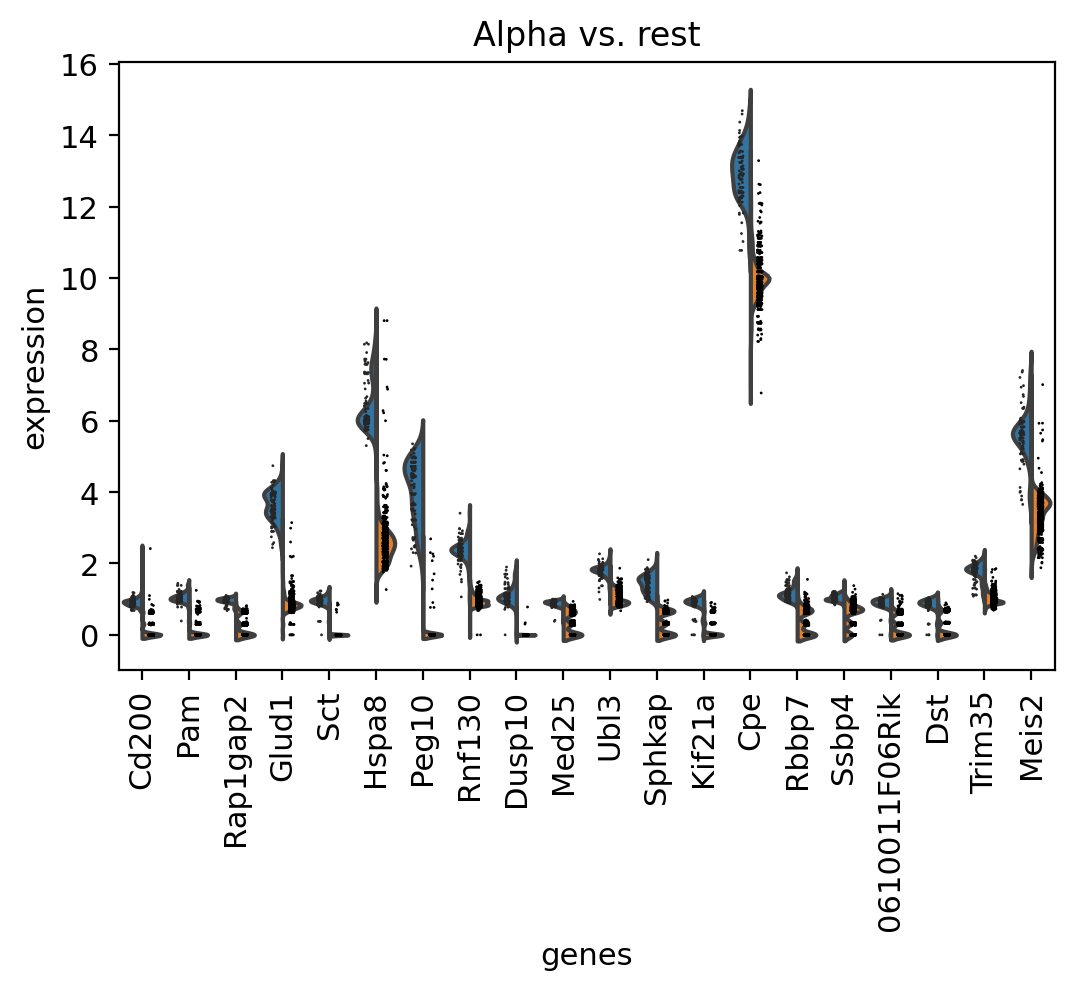

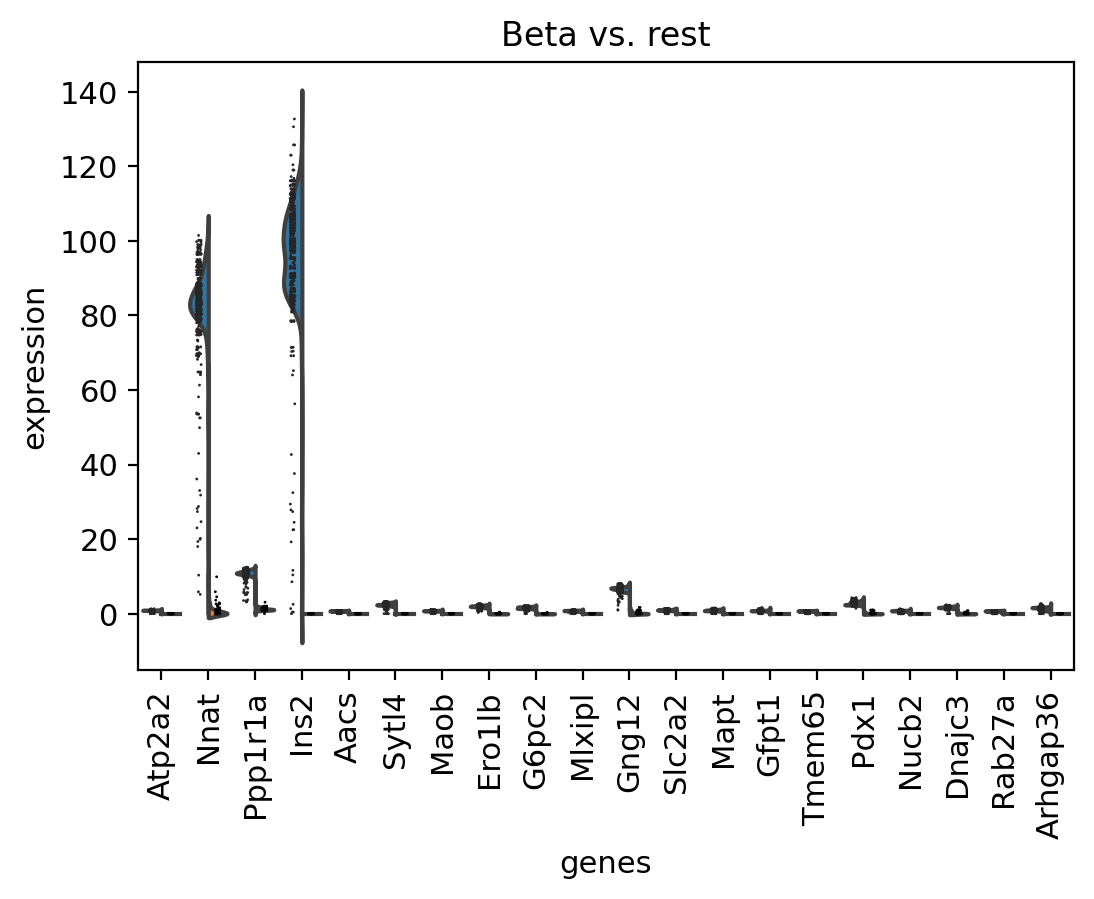

In [19]:
import anndata as ad
terminal_adata = ad.AnnData(terminal_cells, 
                            var=adata[:, adata.var["velocity_genes"]].var)
terminal_adata.obs["KNN_labels"] = terminal_class
sc.tl.rank_genes_groups(terminal_adata, 'KNN_labels', groups=["Alpha", "Beta"])
sc.pl.rank_genes_groups_violin(terminal_adata)

### Perturbation Experiment to Increase Alpha Cell Percentage

In [54]:
top_100_alpha_genes = [i[0] for i in terminal_adata.uns["rank_genes_groups"]["names"][:100]]
top_100_alpha_genes_idx = [np.where(i == adata_raw.var.index[adata.var["velocity_genes"]])[0][0] for i in top_100_alpha_genes]
top_100_alpha_genes_idx = np.unique(np.sort(top_100_alpha_genes_idx))

In [55]:
n_iter = 1000
starting_cells_perturb = np.zeros((n_iter, X.shape[1]))
terminal_cells_perturb = np.zeros((n_iter, X.shape[1]))
y0 = np.median(adata_raw.X[np.ix_(np.where(adata.obs.clusters == "Pre-endocrine")[0], 
                                   adata.var["velocity_genes"])].A, 
               axis=0)
y0_sigma = adata_raw.X[:, np.where(adata.var["velocity_genes"])[0][top_100_alpha_genes_idx]].A.std(axis=0)
for i in range(n_iter):
    
    if (i % 50 == 0):
        print(i)
        with open('terminal_cells_perturb.npy', 'wb') as f:
            np.save(f, np.vstack([starting_cells_perturb, terminal_cells_perturb]))
    
    # Solve for the cell with initial & velocity noise
    y0_noise = np.zeros(y0.shape[0])
    y0_noise[top_100_alpha_genes_idx] += np.random.exponential(y0_sigma)
    y_solution = interpolate(y0+y0_noise, neigh = neigh, pca = pca, umap_reducer = umap_reducer)
    starting_cells_perturb[i] = y_solution[0, :]
    terminal_cells_perturb[i] = y_solution[-1, :]
    
with open('terminal_cells_perturb.npy', 'wb') as f:
    np.save(f, np.vstack([starting_cells_perturb, terminal_cells_perturb]))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [56]:
KNClass = sklearn.neighbors.KNeighborsClassifier(n_neighbors=30)
KNClass.fit(adata_pca, adata_raw.obs.clusters)
terminal_pca = pca.transform(np.nan_to_num(np.log1p(terminal_cells_perturb)))
terminal_class = KNClass.predict(terminal_pca)
terminal_probs = KNClass.predict_proba(terminal_pca)
print(np.sum(terminal_class == "Alpha") / terminal_class.shape[0])

0.23


### Visualization of a sample perturbed path

In [ ]:
# Lower dimensionality
ending_pt_pca = pca.transform(np.nan_to_num(np.log1p(y_solution)))
ending_pt = umap_reducer.transform(ending_pt_pca)
        
# Plot UMAP directions
plt.figure(figsize=(10,3))
plt.subplot(1, 3, 1)
plt.scatter(adata_umap[:, 0], adata_umap[:, 1], 
            s=1, alpha=0.05,
            c=adata.uns["clusters_colors"][adata.obs.clusters.cat.codes.to_numpy()])
plt.scatter(ending_pt[:, 0], 
            ending_pt[:, 1], 
            c=np.arange(ending_pt.shape[0]), 
            cmap="viridis",
            s=20
           )
plt.colorbar()
plt.scatter(ending_pt[0, 0], ending_pt[0, 1], s=20, color="red")
plt.gca().set_aspect('equal', 'datalim')

# Plot PCA directions
plt.subplot(1, 3, 2)
plt.scatter(adata_pca[:, 0], 
            adata_pca[:, 1], 
            s=1, 
            alpha=0.2, 
            c=adata.uns["clusters_colors"][adata.obs.clusters.cat.codes.to_numpy()])
plt.scatter(ending_pt_pca[:, 0], 
            ending_pt_pca[:, 1], 
            c=np.arange(ending_pt.shape[0]), 
            cmap="viridis",
            s=20
           )
plt.colorbar()
plt.scatter(ending_pt_pca[0, 0], ending_pt_pca[0, 1], 
            s=20, color="red")
plt.gca().set_aspect('equal', 'datalim')

plt.subplot(1, 3, 3)
plt.scatter(adata_pca[:, 1], 
            adata_pca[:, 2], 
            s=1, 
            alpha=0.2, c=adata.uns["clusters_colors"][adata.obs.clusters.cat.codes.to_numpy()])
plt.scatter(ending_pt_pca[:, 1], 
            ending_pt_pca[:, 2], 
            c=np.arange(ending_pt.shape[0]), 
            cmap="viridis",
            s=20
           )
plt.colorbar()
plt.scatter(ending_pt_pca[0, 1], ending_pt_pca[0, 2], 
            s=20, color="red")
plt.gca().set_aspect('equal', 'datalim')
plt.show()

In [ ]:
vae_embedding = encoder.predict(adata_raw.X.A[:, adata.var["velocity_genes"]])
vae_embedding_progress = encoder.predict(y_solution)

vae_reducer = umap.UMAP(random_state=42)
vae_embedding_umap = vae_reducer.fit_transform(vae_embedding)
vae_embedding_progress_umap = vae_reducer.transform(vae_embedding_progress)

plt.figure()
plt.scatter(vae_embedding_umap[:, 0], 
            vae_embedding_umap[:, 1], 
            c=adata.uns["clusters_colors"][adata.obs.clusters.cat.codes.to_numpy()],
            s=1, 
            alpha=0.5)
plt.scatter(vae_embedding_progress_umap[:, 0], 
            vae_embedding_progress_umap[:, 1], 
            c=np.arange(vae_embedding_progress_umap.shape[0]), 
            cmap="viridis",
            s=20
           )
plt.colorbar()
plt.scatter(vae_embedding_progress_umap[0, 0], vae_embedding_progress_umap[0, 1], s=20, color="red")
plt.gca().set_aspect('equal', 'datalim')
plt.title('AE Embedding projection', fontsize=16)
plt.show()

### Result Visualization

In [6]:
import plotly.graph_objects as go

In [7]:
all_cells_perturb = np.load('terminal_cells_perturb.npy')
all_cells = np.load('terminal_cells.npy')

terminal_cells_perturb = all_cells_perturb[int(all_cells_perturb.shape[0]/2):, :]
terminal_cells = all_cells[int(all_cells.shape[0]/2):, :]

In [8]:
pca = sklearn.decomposition.PCA(n_components=30)
adata_pca = pca.fit_transform(np.log1p(adata_raw.X.A[:, adata.var["velocity_genes"]]))
umap_reducer = umap.UMAP(random_state=42)
adata_umap = umap_reducer.fit_transform(adata_pca)
neigh = sklearn.neighbors.NearestNeighbors(n_neighbors=30)
neigh.fit(adata_pca)

NearestNeighbors(n_neighbors=30)

In [9]:
KNClass = sklearn.neighbors.KNeighborsClassifier(n_neighbors=30)
KNClass.fit(adata_pca, adata_raw.obs.clusters)

terminal_pca = pca.transform(np.nan_to_num(np.log1p(terminal_cells)))
terminal_class = KNClass.predict(terminal_pca)

terminal_perturb_pca = pca.transform(np.nan_to_num(np.log1p(terminal_cells_perturb)))
terminal_perturb_class = KNClass.predict(terminal_perturb_pca)

In [14]:
color_node = ['#ff7f0e', '#98e08a', '#2077b4', '#94678b']
color_link = ['#ff7f0e', '#98e08a', '#2077b4', '#94678b']

label = ["Pre-endocrine", "Beta", "Alpha"]
source = [0, 0, 0]
target = [1, 2, 3]
value = [np.sum(terminal_class == "Beta") / terminal_class.shape[0], 
         np.sum(terminal_class == "Alpha") / terminal_class.shape[0]]
# data to dict, dict to sankey
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node)
# plot
fig = go.Figure(data)
fig.update_layout(
    autosize=False,
    width=350,
    height=350)
fig.write_image("sankey-baseline.png", width=350, height=350, scale=3)
fig.show()

In [15]:
value = [np.sum(terminal_perturb_class == "Beta") / terminal_perturb_class.shape[0], 
         np.sum(terminal_perturb_class == "Alpha") / terminal_perturb_class.shape[0]]
# data to dict, dict to sankey
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node)
# plot
fig = go.Figure(data)
fig.update_layout(
    autosize=False,
    width=350,
    height=350)
fig.write_image("sankey-perturbed.png", width=350, height=350, scale=3)
fig.show()